# TP Compte Rendu - Régression logistique <a class="tocSkip">

# Régularisation de Tikhonov

In [1]:
import numpy as np
from scipy.optimize import check_grad
from diabeticRetinopathyUtils import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from numpy import inf
from time import time
X, Y = load_diabetic_retinopathy("diabeticRetinopathy.csv")

## Question 1.1

En posant $ \widetilde{X} = (\tilde{x_i}, \tilde{x_2},\dots, \tilde{x_{n-1}},\tilde{x_n} )  \in \mathbb R^{(p+1) \times n }​$ ,où $ \tilde{x_i} =\begin{pmatrix} 1 \\ x_i \end{pmatrix}  \in R^{p+1}​$  ,  $\tilde{\omega} = \begin{pmatrix} \omega_0 \\ \omega_1 \end{pmatrix}  \in \mathbb R^{p+1}​$ et la matrice diagonale
$$
A = diag(0,1,1,\dots, 1) = 
\begin{pmatrix} 
0& 0& 0& \dots &\dots &0 \\
0& 1& 0& \dots &\dots &0 \\
\vdots &\vdots& \vdots&  \ddots & & \vdots\\
\vdots &\vdots &\vdots& &\ddots & \vdots \\
0& 0& 0& \dots  &\dots &1 
\end{pmatrix}
$$

  Alors la fonction peut être ecrits sous format ci-dessous:

$$ f_1: (\tilde{\omega}) \mapsto \frac{1}{n} \sum_{i=1}^{n} \log(1+exp(-y_i \tilde{x}_i^T\tilde{\omega})) + \frac{\rho}{2}\tilde{\omega}^ TA \tilde{\omega} $$

  Ainsi on obtient le gradient:
        $$
        \begin{aligned}
        \nabla{f_1}(\tilde{\omega}) &= \frac{1}{n}\sum_{i=1}^{n}\frac{-e^{-y_i\tilde x_i^T \tilde \omega}y_i\tilde{\mathbf{x}}_i}{1+e^{-y_i\tilde x_i^T \tilde \omega}} + \rho A\tilde{\mathbf{\omega}} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{-y_i\tilde{\mathbf{x}}_i}{1+e^{y_i\tilde x_i^T \tilde \omega}} + 
        \rho A\tilde{\mathbf{\omega}}
        \end{aligned}
        $$
    </p>
    <p>
        et la matrice hessienne:
        $$
        \begin{aligned}
        \mathbf{H} = \nabla^2f_1(\tilde{\omega}) &= \frac{1}{n}\sum_{i=1}^{n}\frac{e^{y_i\tilde x_i^T \tilde \omega}(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})^2} + \rho A \\
        & = \frac{1}{n}\sum_{i=1}^{n}\frac{(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho A
        \end{aligned}
        $$
Soient $\omega \in \mathbb{R}^{p+1}$, on a:
        $$
        \begin{aligned}
        \omega^TH\omega &= \frac{1}{n}\sum_{i=1}^{n}\frac{\omega^T (y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T \omega}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \omega^T A \omega \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{(\omega^T y_i\tilde{\mathbf{x}}_i)(\omega^T y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \omega^T A^2 \omega \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{\|\omega^T y_i\tilde{\mathbf{x}}_i\|_2^2}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \|A\omega\|_2^2 \geq 0
        \end{aligned}
        $$
    </p>
    <p>Donc, la matrice hessienne est semi-définie positive, la fonction $f_1$ est convexe.</p>

## Question 1.2

In [2]:
def objective_fun(X, Y, omega_0, omega, rho=1.0 / X.shape[0]):
    """
    X： matrix de taille n*p
    Y: vecteur de taille n
    omega: vecteur de dimension p
    omega0 : un nombre réel 
    """

    n, p = X.shape
    omega_tilde = np.append(omega_0, omega)
    X_tilde = np.c_[np.ones(n), X]
    A = np.identity(p + 1)
    A[0][0] = 0

    fun_value = 0
    grad_value = np.zeros(p + 1)
    hess_value = np.zeros((p + 1, p + 1))

    for i in range(n):
        item = np.exp(Y[i] * np.dot(X_tilde[i], omega_tilde))
        fun_value = fun_value + np.log(1.0 + 1.0 / item)
        grad_value = grad_value + (-Y[i] * X_tilde[i]) / (1.0 + item)
        hess_value = hess_value + (
            Y[i] * Y[i] * np.outer(X_tilde[i], X_tilde[i])) / (
                (1. + item) * (1. + 1.0 / item))

    fun_value = fun_value / n + rho / 2.0 * np.linalg.norm(omega_tilde)**2
    grad_value = grad_value / n + rho * omega_tilde
    hess_value = hess_value / n + rho * A

    return fun_value, grad_value, hess_value

In [3]:
omega = np.arange(19)
n, p = X.shape
obj = lambda omega: objective_fun(X, Y, omega[0], omega[1:])[0]
grad = lambda omega: objective_fun(X, Y, omega[0], omega[1:])[1]

print("The difference of gradient is: %0.12f" % check_grad(
    obj, grad, np.zeros(20)))

The difference of gradient is: 0.000005578095


In [4]:
omega = np.arange(19)
n, p = X.shape
grad_sum = lambda omega: objective_fun(X, Y, omega[0], omega[1:])[1].sum()
hess = lambda omega: objective_fun(X, Y, omega[0], omega[1:])[2].sum(axis=1)
check_grad(obj, grad, np.zeros(20))
print("The difference of hessian is: %0.12f" % check_grad(
    grad_sum, hess, np.zeros(20)))

The difference of hessian is: 0.000868842017


Alors, le gradient et la matrice hessienne sont bien vérifié

## Question 1.3

In [5]:
def log(func):
    def warpper(*args, **kw):
        t0 = time()
        fun_val, sln, re_list = func(*args, **kw)
        t_nls = time() - t0
        indice = np.arange(len(re_list))
        plt.semilogy(indice, re_list)
        plt.xlabel("Nombre d'iteration")
        plt.ylabel("Norme de gradien")
        plt.grid(True)
        plt.show()
        print("The value minimal of the objective function is:", fun_val)
        print("Done in %0.3fs, number of iterations: %d" % (t_nls,
                                                            len(re_list)))
        return sln

    return warpper

In [6]:
@log
def method_newtown(omega):
    w = omega
    [fun_v, grad_v, hess_v] = objective_fun(X, Y, omega[0], omega[1:])
    norme_list = list()
    nbIt = 0
    norm = np.linalg.norm(grad_v)

    while (norm > 10.0e-10):
        w = w - np.linalg.inv(hess_v).dot(grad_v)
        [fun_v, grad_v, hess_v] = objective_fun(X, Y, w[0], w[1:])
        norme_list.append(norm)
        nbIt = nbIt + 1
        norm = np.linalg.norm(grad_v)

    return fun_v, w, norme_list

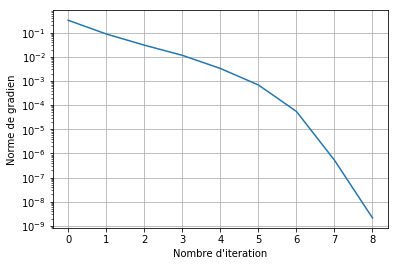

('The value minimal of the objective function is:', 0.53021541868164102)
Done in 0.374s, number of iterations: 9


array([ 0.66803037,  0.29226923, -0.24527947,  5.60379839,  0.98576632,
       -1.82513267, -2.55300745, -1.58325344,  0.43396483,  0.48473152,
       -0.40403518,  0.17251063, -0.57439595,  0.43769677, -0.6203335 ,
        1.23648747,  0.71401475, -0.00590436, -0.14907897, -0.09515229])

In [7]:
method_newtown(np.zeros(p + 1))

## Question 1.4

In [8]:
method_newtown(np.ones(p + 1) * 0.3)

/Users/bolong/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Users/bolong/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/Users/bolong/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/Users/bolong/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
/Users/bolong/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars


LinAlgError: Singular matrix

On a vue que dans cette condition initiale, le matrix de hessian est singulier, c'est à dire son inverse n'existe pas. Donc on ne peut pas utilise cette méthode de trouver une solutions juste.

## Question 1.5

Notons $h_k = -H^{-1}(x_k) \nabla f(x_k)$, 
Notons $\omega^+(\gamma_k)=\omega^k + \gamma_kh_k$, soient $a \in (0,1)$, $b>0$ et $\beta \in (0,1)$, on cherche le premier entier $l$ non-négatif tel que:</p>
    $$f_1(\omega^+(ba^l)) \leq f_1(\omega^k) + \beta ba^l\langle\nabla_{f_1}(\omega^k),\,h_k\rangle$$

Ici, on prend $\beta = 0.5$, ainsi que la recherche linéaire d'Armijo devient équicalente à la recherche linéaire de Taylor.</p>
On fixe $b_0 = 1$ et $b_k = 2\gamma_{k-1}$, c'est un choix classique.</p>
On fixe $a = 0.5$, c'est pour faire un compromis entre la précision de recherche et la vitesse de convergence.</p>

In [9]:
@log
def method_newtown_armijo(omega, epsilon, a, b, beta):
    w = omega
    [fun_v, grad_v, hess_v] = objective_fun(X, Y, w[0], w[1:])
    norm_list = list()
    nbIt = 0
    norm = np.linalg.norm(grad_v)
    gamma = beta

    while (norm > epsilon):
        h_k = np.linalg.inv(hess_v).dot(-grad_v)
        gamma = gamma * 2.0
        w_plus = w + gamma * h_k
        val_plus, grad_plus, hess_plus = objective_fun(X, Y, w_plus[0],
                                                       w_plus[1:])
        while (val_plus > fun_v + beta * gamma * h_k.dot(grad_v)):
            gamma = gamma * a
            w_plus = w + gamma * h_k
            val_plus, grad_plus, hess_plus = objective_fun(
                X, Y, w_plus[0], w_plus[1:])

        w = w_plus
        [fun_v, grad_v, hess_v] = objective_fun(X, Y, w[0], w[1:])
        norm_list.append(norm)
        nbIt = nbIt + 1
        norm = np.linalg.norm(grad_v)

    return fun_v, w, norm_list

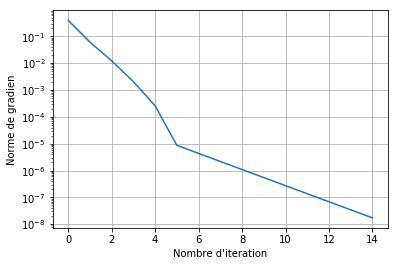

('The value minimal of the objective function is:', 0.53021541868164013)
Done in 1.207s, number of iterations: 15


In [10]:
w = np.ones(p + 1) * 0.3
w_tik = method_newtown_armijo(w, 10e-10, 0.5, 1.0, 0.5)

# Régularisation pour la parcimonie

## Question 2.1
Pourquoi ne peut-on pas utiliser la méthode de Newton pour résoudre ce problème?

Comme la fonction
$$ \underset{\omega \in \mathbb R, \omega_0 \in \mathbb R^p}{\operatorname{min}} \frac{1}{n}
\sum_{i=1}^n \log\left(1+e^{-y_i(x_i^T\omega + \omega_0)}\right) + \rho ||\omega||_1$$
Il est évident que la terme $\rho||\omega||_1 $ n'est pas différentiable en point $\omega = 0$. Donc cette fonction objective n'est pas différentiable. Par conséquent, on ne peut pas utilser la méthode de Newton pour résoudre ce problème.

## Question 2.2

La fonction objective peut être écrit sous la forme ci-dessous:
$$\begin{aligned} 
F_2(\omega, \omega_0)  &= \frac{1}{n}
\sum_{i=1}^n \log\left(1+e^{-y_i(x_i^T\omega + \omega_0)}\right) + \rho ||\omega||_1 \\
&= f_2 + g_2 \\
\end{aligned}$$ 
où
$$\begin{aligned}
f_2(\omega, \omega_0)  &= \frac{1}{n}
\sum_{i=1}^n \log\left(1+e^{-y_i(x_i^T\omega + \omega_0)}\right), \\
g_2(\omega) &=  \rho ||\omega||_1
\end{aligned}$$
D'après le resultat du question précédent et ce que l'on voit sur le cours, on peut facilement déduire que $f_2$ est dérivable et l'opérateur proximal de $g_2$ est facile à calcule. 

On a l'opérateur de proximal de $g_2$:
$$\begin{aligned}
prox_{\gamma g}(x) &= \underset{y \in \mathbb R^p}{\operatorname{argmin}} g(y) + \frac{1}{2\gamma} || y - x||_2^2 \\
& =\underset{y \in \mathbb R^p}{\operatorname{argmin}} \rho||y||_1 + \frac{1}{2\gamma} || y - x||_2^2 \\
& = \underset{y \in \mathbb R^p}{\operatorname{argmin}} \rho\sum_{i=1}^{p}|y_i| + \frac{1}{2\gamma} \sum_{i=1}^p (y_i - x_i)^2 \\
& = \underset{y \in \mathbb R^p}{\operatorname{argmin}} \sum_{i=1}^{p} \left(\rho|y_i| + \frac{1}{2\gamma} (y_i - x_i)^2 \right) \\
&= y^* \\
&= \begin{pmatrix} y^*_1 \\ y^*_2 \\ y^*_3 \\ \vdots \\ y^*_p \end{pmatrix}
\end{aligned}$$
où
$$ y^*_i = \underset{y_i \in \mathbb R}{\operatorname{argmin}} \rho|y_i| + \frac{1}{2\gamma} (y_i - x_i)^2 , i \in [\![1;p]\!], \gamma >0$$
En posant 
$$t(y_i)= \rho|y_i| + \frac{1}{2\gamma} (y_i - x)^2)$$
Alors 

$$ \frac{dt}{dy_i} = +\rho\frac{|y_i|}{y_i} + \frac{1}{\gamma}(y_i-x)$$
En posant $\frac{dt}{dy_i} = 0$, on peut facile d'obtenir le $y^*_i$
$$ y_i^* = \left\{
\begin{align}
\,x_i-\gamma\rho  &,\, si \,& x_i > \gamma\rho \\
\,x_i+\gamma\rho\,  &,\, si \, &x_i < -\gamma\rho \\
\,0 &,\, sinon \\
\end{align} \right.$$



Pour le gradient de $f_2$, on a 
$$
        \begin{aligned}
        \nabla{f_2}(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{-e^{-y_i\tilde x_i^T \tilde \omega}y_i\tilde{\mathbf{x}}_i}{1+e^{-y_i\tilde x_i^T \tilde \omega}} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{-y_i\tilde{\mathbf{x}}_i}{1+e^{y_i\tilde x_i^T \tilde \omega}}
        \end{aligned}
$$
Pour lla matrix hessian, on a
 $$
        \begin{aligned}
        \mathbf{H_2} = \nabla^2f_2(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{e^{y_i\tilde x_i^T \tilde \omega}(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})^2} \\
        & = \frac{1}{n}\sum_{i=1}^{n}\frac{(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})}
        \end{aligned}
$$

Soient $\omega \in \mathbb{R}^{p+1}$, on a:
$$
\begin{aligned}
\omega^TH_2\omega &= \frac{1}{n}\sum_{i=1}^{n}\frac{\omega^T (y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T \omega}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \\
&= \frac{1}{n}\sum_{i=1}^{n}\frac{(\omega^T y_i\tilde{\mathbf{x}}_i)(\omega^T y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \\
 &= \frac{1}{n}\sum_{i=1}^{n}\frac{\|\omega^T y_i\tilde{\mathbf{x}}_i\|_2^2}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \geq 0
\end{aligned}
$$

Donc, la matrice hessienne de $f_2$ est semi-définie positive, la fonction $f_2$ est convexe.
  $$
        \begin{aligned}
        g_2(\omega_0, \omega) &= \rho\|\omega\|_1 \\
        &= \rho \sum_{i=1}^{n}|\omega_i|
        \end{aligned}
    $$
    </p>
    <p>La fonction de valeur absolue est convexe pour chaque élément de $\omega$, pour $\rho \geq 0$, $g_2$ est aussi convexe.</p>
    <p>Donc $F_2 = f_2 + g_2$ est convexe pour $\rho \geq 0$.</p>


## Question 2.3

In [11]:
def prox_g(x, rho, gamma):
    if (rho < 0 or gamma < 0):
        raise ValueError(
            "Value rho or gamma have to be positive: rho=%2.2f, gamma=%2.2f" %
            (rho, gamma))

    def prox_real(x):
        if (x > rho * gamma):
            return x - rho * gamma
        elif (x < -rho * gamma):
            return x + rho * gamma
        else:
            return 0.0

    return np.array(list(map(prox_real, x)))


def reg_obj_fun(X, Y, omega_0, omega, rho):
    """
    X： matrix de taille n*p
    Y: vecteur de taille n
    omega: vecteur de dimension p
    omega0 : un nombre réel 
    """
    n, p = X.shape
    omega_tilde = np.append(omega_0, omega)
    X_tilde = np.c_[np.ones(n), X]

    fun_value = 0.0

    for i in range(n):
        item = np.exp(-Y[i] * np.dot(X_tilde[i], omega_tilde))
        fun_value = fun_value + np.log(1.0 + item)

    fun_value = fun_value / n + rho * np.absolute(omega_tilde).sum()

    return fun_value


def f(X, Y, omega_0, omega, rho, value_only=False):
    """
    X： matrix de taille n*p
    Y: vecteur de taille n
    omega: vecteur de dimension p
    omega0 : un nombre réel 
    """

    n, p = X.shape
    omega_tilde = np.append(omega_0, omega)
    X_tilde = np.c_[np.ones(n), X]

    fun_value = 0
    grad_value = np.zeros(p + 1)
    hess_value = np.zeros((p + 1, p + 1))

    for i in range(n):
        item = np.exp(Y[i] * np.dot(X_tilde[i], omega_tilde))
        fun_value = fun_value + np.log(1.0 + 1.0 / item)
        if (not value_only):
            grad_value = grad_value + (-Y[i] * X_tilde[i]) / (1.0 + item)
            hess_value = hess_value + (
                Y[i] * Y[i] * np.outer(X_tilde[i], X_tilde[i])) / (
                    (1. + item) * (1. + 1.0 / item))

    fun_value = fun_value / n
    if (not value_only):
        grad_value = grad_value / n
        hess_value = hess_value / n

    if (not value_only):
        return fun_value, grad_value, hess_value
    else:
        return fun_value

In [12]:
@log
def method_proximal(omega, epsilon, a, b, rho):
    w = omega
    f_v, f_grad, f_hess = f(X, Y, omega[0], omega[1:], rho)

    nbIt = 0
    old_val = inf
    changement = np.fabs(f_v - old_val)
    deltaList = list()

    while (changement > epsilon):
        gamma = b  # initialiser la valeur de gamma
        w_plus = prox_g(w - gamma * f_grad, rho, gamma)
        val_plus = f(X, Y, w_plus[0], w_plus[1:], rho, value_only=True)

        while (val_plus > f_v + f_grad.dot(w_plus - w) +
               1.0 / gamma * np.linalg.norm(w_plus - w)**2):
            gamma = gamma * a
            w_plus = prox_g(w - gamma * f_grad, rho, gamma)
            val_plus = f(X, Y, w_plus[0], w_plus[1:], rho, value_only=True)

        w = w_plus
        old_val = f_v
        f_v, f_grad, f_hess = f(X, Y, w[0], w[1:], rho)
        nbIt = nbIt + 1
        changement = np.fabs(f_v - old_val)
        deltaList.append(changement)

    return reg_obj_fun(X, Y, w[0], w[1:], rho), w, deltaList

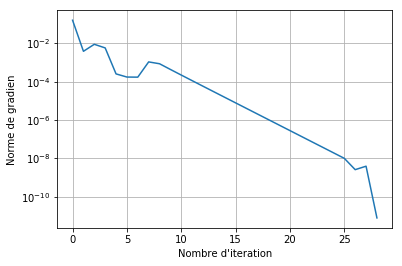

('The value minimal of the objective function is:', 0.68889107410077777)
Done in 1.006s, number of iterations: 29


In [13]:
w = np.ones(p + 1) * 0.3
w_prox = method_proximal(w, 10e-10, 0.5, 2, 0.1)

# Comparaison

## Question 3.1

En comparant les propriétés des deux problèmes d’optimisation:
1. Les deux fonctions objectives sont toutes convexes.
2. La fonction obtient par la régularisation de Tikhonov est différentible, l'autre n'est pas différentiable.
3. Pour $\omega$ qu'on obtient, la régularisation de Tiknonov utilise toutes les données explicatives, la régularisation pour la parcimoine ne utilise qu'une partie des données.

## Question 3.2

In [14]:
y_pred_nls = np.sign(np.c_[np.ones(n), X].dot(w_tik))
y_pred_pgls = np.sign(np.c_[np.ones(n), X].dot(w_prox))
print("The chance level is: %f" % max(np.mean(Y == 1), 1 - np.mean(Y == 1)))
print("The score by Newton method with line search is: %f" %
      np.mean(Y == y_pred_nls))
print("The score by proximal gradient method with line search is: %f" %
      np.mean(Y == y_pred_pgls))

#print('-'*60)
print("Classification report for Newton method")
print(classification_report(Y, y_pred_nls))
#print('-'*60)
print("Classification report for proximal gradient method")
print(classification_report(Y, y_pred_pgls))

The chance level is: 0.530843
The score by Newton method with line search is: 0.741095
The score by proximal gradient method with line search is: 0.592528
Classification report for Newton method
             precision    recall  f1-score   support

       -1.0       0.69      0.82      0.75       540
        1.0       0.81      0.67      0.73       611

avg / total       0.75      0.74      0.74      1151

Classification report for proximal gradient method
             precision    recall  f1-score   support

       -1.0       0.56      0.63      0.59       540
        1.0       0.63      0.56      0.59       611

avg / total       0.60      0.59      0.59      1151



En comparant les solutions obtenues avec les deux types de régularisation:

1. La performance de la méthode de Newton est mieux que la méthode de gradient proximal.

2. Précisément, pour le f1-score, la méthode de Newton est encore mieux.
